In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from utils import *
from dataset import *

## simulate test data

In [2]:
testset = TwoArmLinkTestDataset()

100%|██████████| 100/100 [00:00<00:00, 116.15it/s]


In [3]:
torch.save(testset, 'two_links_arm_test')

In [4]:
t = testset[0]['adapt']
x = t['true_pos']
z = t['noisy_pos']

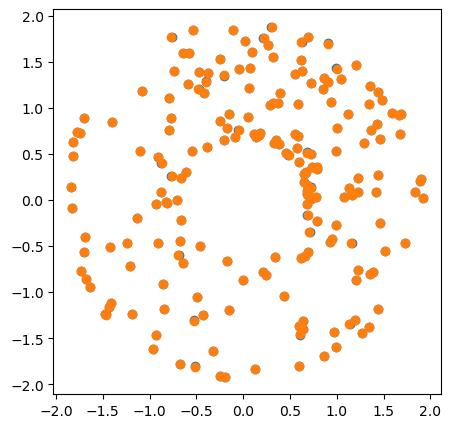

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(*x.numpy())
plt.scatter(*z.numpy())

In [6]:
t = testset[0]['test']
init_pos = t['init_angle'].numpy()
target_pos = t['target_pos'].numpy()
true_pos = t['true_pos'].numpy()
for pos in true_pos:
	print(pos)
	break

[ 1.17333388 -0.50178329]


In [7]:
singular = []
flag = False
for i in range(100):
	t = testset[i]['test']
	init_pos = t['init_angle'].numpy()
	target_pos = t['target_pos'].numpy()
	true_pos = t['true_pos'].numpy()
	for pos in true_pos:
		if np.allclose(pos, target_pos):
			flag = True
			break
	if not flag:
		singular.append(i) 
print(len(singular)/100)

0.0
